In [122]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score, GridSearchCV, train_test_split
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_error
from sklearn.impute import KNNImputer, SimpleImputer
from sklearn.compose import ColumnTransformer

In [123]:
data = pd.read_csv("house_prices_selection.csv")

In [124]:
data.shape

(1460, 32)

In [125]:
numerical_features = data.select_dtypes(include=[np.number]).columns.tolist()
categorical_features = data.select_dtypes(include=['object']).columns.tolist()
boolean_features = data.select_dtypes(include=['bool']).columns.tolist()

if 'SalePrice' in numerical_features:
    numerical_features.remove('SalePrice')

for cols in boolean_features:
    data[cols] = data[cols].astype(int)
numerical_features.extend(boolean_features)

In [126]:
print(f"Coloane numerice ({len(numerical_features)}): {numerical_features}")
print(f"\nColoane categorice ({len(categorical_features)}): {categorical_features}")

Coloane numerice (26): ['EVI', 'ZoningScore', 'Price_per_m^2', 'PDI', 'LotFrontage', 'LotArea', 'WoodDeckSF', 'OpenPorchSF', 'FullBath', 'GarageCars', 'GarageArea', 'OverallQual', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'GrLivArea', 'TotalBsmtSF', '1stFlrSF', 'MSZoning_RL', 'LotConfig_CulDSac', 'LandContour_HLS', 'LotShape_IR2', 'Condition1_Norm', 'Condition1_Feedr', 'LotShape_Reg', 'MSZoning_RM']

Coloane categorice (5): ['KitchenQual', 'PavedDrive', 'BsmtQual', 'CentralAir', 'Foundation']


In [127]:
df_dropna = data.dropna()
print("Shape after dropna:", df_dropna.shape)

Shape after dropna: (1164, 32)


In [128]:
X = df_dropna.drop("SalePrice", axis=1)
y = df_dropna["SalePrice"]

X_train_A, X_test_A, y_train_A, y_test_A = train_test_split(X, y, test_size=0.2, random_state=42)

In [129]:
preprocessor_dropna = ColumnTransformer([
    ("num", "passthrough", [col for col in numerical_features if col != "SalePrice"]),
    ("cat", OneHotEncoder(handle_unknown="ignore"), categorical_features)
])

pipe_dropna = Pipeline([
    ("prep", preprocessor_dropna),
    ("model", LinearRegression())
])

In [130]:
pipe_dropna.fit(X_train_A, y_train_A)
y_pred_A = pipe_dropna.predict(X_test_A)

rmse_A =np.sqrt(mean_squared_error(y_test_A, y_pred_A))

print("RMSE (dropna):", rmse_A)

RMSE (dropna): 35344.636999656526


In [131]:
X = data.drop("SalePrice", axis=1)
y = data["SalePrice"]

X_train_B, X_test_B, y_train_B, y_test_B = train_test_split(X, y, test_size=0.2, random_state=42)

In [132]:
numeric_transformer = Pipeline([
    ("imputer", SimpleImputer(strategy="median"))
])

categorical_transformer = Pipeline([
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("encoder", OneHotEncoder(handle_unknown="ignore"))
])

preprocessor_imputer = ColumnTransformer([
    ("num", numeric_transformer, [col for col in numerical_features if col != "SalePrice"]),
    ("cat", categorical_transformer, categorical_features)
])

pipe_imputer = Pipeline([
    ("prep", preprocessor_imputer),
    ("model", LinearRegression())
])

In [133]:
pipe_imputer.fit(X_train_B, y_train_B)
y_pred_B = pipe_imputer.predict(X_test_B)

rmse_B = np.sqrt(mean_squared_error(y_test_B, y_pred_B))

print("RMSE (with SimpleImputer):", rmse_B)

RMSE (with SimpleImputer): 34363.9051820428


In [134]:
print("Dropna RMSE:        ", rmse_A)
print("SimpleImputer RMSE: ", rmse_B)

Dropna RMSE:         35344.636999656526
SimpleImputer RMSE:  34363.9051820428


Using SimpleImputer preserved all data and produced better predictive performance.

Therefore, imputing missing values is the better preprocessing strategy for this dataset.

**Cerinta 18-Nov**

In [135]:
numeric_transformer = Pipeline([
    ("imputer", SimpleImputer(strategy="median"))
])

categorical_transformer = Pipeline([
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("encoder", OneHotEncoder(handle_unknown="ignore"))
])

preprocessor = ColumnTransformer([
    ("num", numeric_transformer, numerical_features),
    ("cat", categorical_transformer, categorical_features)
])

In [136]:
X = data.drop("SalePrice", axis=1)
y = data["SalePrice"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

In [137]:
pipe_lr = Pipeline([
    ("prep", preprocessor),
    ("regressor", LinearRegression())
])

pipe_lr.fit(X_train, y_train)
y_pred_lr = pipe_lr.predict(X_test)
mae = mean_absolute_error(y_test, y_pred_lr)
rmse = np.sqrt(mean_squared_error(y_test, y_pred_lr))
r2 = r2_score(y_test, y_pred_lr)

print(f"Rezultat LR")
print(f"MAE: {mae:,.2f}")
print(f"RMSE: {rmse:,.2f}")
print(f"R² Score: {r2:.4f}")

Rezultat LR
MAE: 21,924.28
RMSE: 34,363.91
R² Score: 0.8460


In [138]:
results = {}
results["linear_regression"] = {
        'MAE': mae,
        'RMSE': rmse,
        'R2': r2
    }

In [139]:
param_grid_dt = {
    'regressor__max_depth': [None, 5, 10, 15, 20],
    'regressor__min_samples_split': [2, 5, 10],
    'regressor__min_samples_leaf': [1, 2, 4, 8],
    'regressor__max_features': ['sqrt', 'log2', None],
    'regressor__criterion': ['squared_error', 'friedman_mse']
}

In [140]:
pipe_dt = Pipeline([
    ("prep", preprocessor),
    ("regressor", DecisionTreeRegressor(random_state=42))
])

grid_dt = GridSearchCV(
    pipe_dt,
    param_grid=param_grid_dt,
    cv=5,
    scoring="neg_mean_squared_error",
    n_jobs=-1
)

grid_dt.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('prep',
                                        ColumnTransformer(transformers=[('num',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer(strategy='median'))]),
                                                                         ['EVI',
                                                                          'ZoningScore',
                                                                          'Price_per_m^2',
                                                                          'PDI',
                                                                          'LotFrontage',
                                                                          'LotArea',
                                                                          'WoodDeckSF',
                                                                          'OpenPorchSF',
                                                                          'FullBath',
                                                                          'GarageCars',
                                                                          'GarageArea',
                                                                          'OverallQual',
                                                                          'YearBuilt',
                                                                          'YearRemodAdd',
                                                                          'MasVnrArea',
                                                                          'GrLivArea'...
                                                                          'Foundation'])])),
                                       ('regressor',
                                        DecisionTreeRegressor(random_state=42))]),
             n_jobs=-1,
             param_grid={'regressor__criterion': ['squared_error',
                                                  'friedman_mse'],
                         'regressor__max_depth': [None, 5, 10, 15, 20],
                         'regressor__max_features': ['sqrt', 'log2', None],
                         'regressor__min_samples_leaf': [1, 2, 4, 8],
                         'regressor__min_samples_split': [2, 5, 10]},
             scoring='neg_mean_squared_error')

In [141]:
y_pred_dt = grid_dt.predict(X_test)
mae = mean_absolute_error(y_test, y_pred_dt)
rmse = np.sqrt(mean_squared_error(y_test, y_pred_dt))
r2 = r2_score(y_test, y_pred_dt)

print(f"Rezultat LR")
print(f"MAE: {mae:,.2f}")
print(f"RMSE: {rmse:,.2f}")
print(f"R² Score: {r2:.4f}")
grid_dt.best_params_

Rezultat LR
MAE: 21,075.37
RMSE: 32,031.42
R² Score: 0.8662


{'regressor__criterion': 'squared_error',
 'regressor__max_depth': 10,
 'regressor__max_features': None,
 'regressor__min_samples_leaf': 4,
 'regressor__min_samples_split': 10}

In [142]:
results["decision_tree"] = {
        'MAE': mae,
        'RMSE': rmse,
        'R2': r2
    }

In [143]:
param_grid_rf = {
    'regressor__n_estimators': [100, 300],
    'regressor__max_depth': [10, 20, None],
    'regressor__min_samples_leaf': [1, 2, 4],
    'regressor__min_samples_split': [2, 5],
    'regressor__max_features': ['sqrt', 'log2'],
    'regressor__bootstrap': [True]
}

In [144]:
pipe_rf = Pipeline([
    ("prep", preprocessor),
    ("regressor", RandomForestRegressor(random_state=42))
])

grid_rf = GridSearchCV(
    pipe_rf,
    param_grid=param_grid_rf,
    cv=3,   # reduce to 3 to save time
    scoring="neg_mean_squared_error",
    n_jobs=-1
)

grid_rf.fit(X_train, y_train)

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('prep',
                                        ColumnTransformer(transformers=[('num',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer(strategy='median'))]),
                                                                         ['EVI',
                                                                          'ZoningScore',
                                                                          'Price_per_m^2',
                                                                          'PDI',
                                                                          'LotFrontage',
                                                                          'LotArea',
                                                                          'WoodDeckSF',
                                                                          'OpenPorchSF',
                                                                          'FullBath',
                                                                          'GarageCars',
                                                                          'GarageArea',
                                                                          'OverallQual',
                                                                          'YearBuilt',
                                                                          'YearRemodAdd',
                                                                          'MasVnrArea',
                                                                          'GrLivArea'...
                                                                          'CentralAir',
                                                                          'Foundation'])])),
                                       ('regressor',
                                        RandomForestRegressor(random_state=42))]),
             n_jobs=-1,
             param_grid={'regressor__bootstrap': [True],
                         'regressor__max_depth': [10, 20, None],
                         'regressor__max_features': ['sqrt', 'log2'],
                         'regressor__min_samples_leaf': [1, 2, 4],
                         'regressor__min_samples_split': [2, 5],
                         'regressor__n_estimators': [100, 300]},
             scoring='neg_mean_squared_error')

In [145]:
y_pred_rf = grid_rf.predict(X_test)
mae = mean_absolute_error(y_test, y_pred_rf)
rmse = np.sqrt(mean_squared_error(y_test, y_pred_rf))
r2 = r2_score(y_test, y_pred_rf)

print(f"Rezultat RF")
print(f"MAE: {mae:,.2f}")
print(f"RMSE: {rmse:,.2f}")
print(f"R² Score: {r2:.4f}")


results["random_forest"] = {
        'MAE': mae,
        'RMSE': rmse,
        'R2': r2
    }

Rezultat RF
MAE: 16,747.99
RMSE: 28,016.65
R² Score: 0.8977


In [146]:
grid_rf.best_params_

{'regressor__bootstrap': True,
 'regressor__max_depth': None,
 'regressor__max_features': 'log2',
 'regressor__min_samples_leaf': 1,
 'regressor__min_samples_split': 2,
 'regressor__n_estimators': 100}

In [147]:
results

{'linear_regression': {'MAE': 21924.279794299066,
  'RMSE': np.float64(34363.9051820428),
  'R2': 0.8460459245848057},
 'decision_tree': {'MAE': 21075.366571307917,
  'RMSE': np.float64(32031.42192714047),
  'R2': 0.8662361987012862},
 'random_forest': {'MAE': 16747.98852739726,
  'RMSE': np.float64(28016.64816112911),
  'R2': 0.8976663373913597}}

Random Forest performs best
* Lowest error (MAE, RMSE)
* Highest R²
* Most robust and least sensitive to noise

Decision Tree improves over Linear Regression
* Learns nonlinear splits
* But limited without ensembles → still less stable than RF

Linear Regression weakest model
* Assumes linear relationships
* Cannot capture complex interactions like quality × area

**19-Nov**

In [148]:
!pip install catboost

In [149]:
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
from sklearn.metrics import mean_squared_error

In [150]:
preprocess = ColumnTransformer([
    ("num", SimpleImputer(strategy="median"), numerical_features),
    ("cat", Pipeline([
        ("imputer", SimpleImputer(strategy="most_frequent")),
        ("onehot", OneHotEncoder(handle_unknown="ignore"))
    ]), categorical_features)
])

In [151]:
models = {
    "XGBoost": XGBRegressor(
        n_estimators=500,
        learning_rate=0.05,
        max_depth=6,
        subsample=0.8,
        colsample_bytree=0.8,
        eval_metric="rmse",
        random_state=42
    ),
    "LightGBM": LGBMRegressor(
        n_estimators=500,
        learning_rate=0.05,
        random_state=42
    )
}

for name, model in models.items():
    pipe = Pipeline([
        ("preprocess", preprocess),
        ("regressor", model)
    ])

    pipe.fit(X_train, y_train)
    preds = pipe.predict(X_test)

    results[name] = {
        "MAE": mean_absolute_error(y_test, preds),
        "RMSE": np.sqrt(mean_squared_error(y_test, preds)),
        "R2": r2_score(y_test, preds)
    }


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001720 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2738
[LightGBM] [Info] Number of data points in the train set: 1168, number of used features: 43
[LightGBM] [Info] Start training from score 181441.541952


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


In [152]:
for col in categorical_features:
    X_train[col] = X_train[col].fillna("missing")
    X_test[col] = X_test[col].fillna("missing")

In [153]:
catboost_model = CatBoostRegressor(
    iterations=500,
    depth=8,
    learning_rate=0.05,
    loss_function="RMSE",
    verbose=False,
    random_state=42
)

cat_model = CatBoostRegressor(verbose=False)
cat_features_idx = [X.columns.get_loc(col) for col in categorical_features]

catboost_model.fit(
    X_train, y_train,
    cat_features=cat_features_idx
)

preds_cat = catboost_model.predict(X_test)

results["CatBoost"] = {
    "MAE": mean_absolute_error(y_test, preds_cat),
    "RMSE": np.sqrt(mean_squared_error(y_test, preds_cat)),
    "R2": r2_score(y_test, preds_cat)
}

In [154]:
results

{'linear_regression': {'MAE': 21924.279794299066,
  'RMSE': np.float64(34363.9051820428),
  'R2': 0.8460459245848057},
 'decision_tree': {'MAE': 21075.366571307917,
  'RMSE': np.float64(32031.42192714047),
  'R2': 0.8662361987012862},
 'random_forest': {'MAE': 16747.98852739726,
  'RMSE': np.float64(28016.64816112911),
  'R2': 0.8976663373913597},
 'XGBoost': {'MAE': 11314.7001953125,
  'RMSE': np.float64(18863.664967338664),
  'R2': 0.953608512878418},
 'LightGBM': {'MAE': 11598.311482789413,
  'RMSE': np.float64(21923.336007510472),
  'R2': 0.9373386934641905},
 'CatBoost': {'MAE': 11367.229382487683,
  'RMSE': np.float64(18978.219741523215),
  'R2': 0.9530433498095481}}

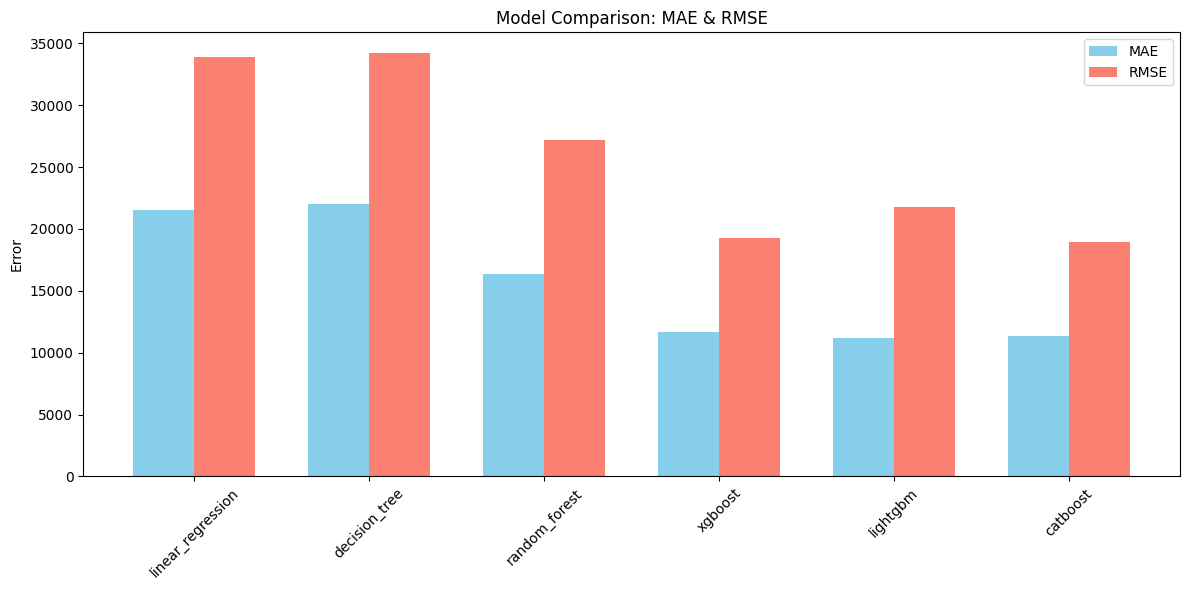

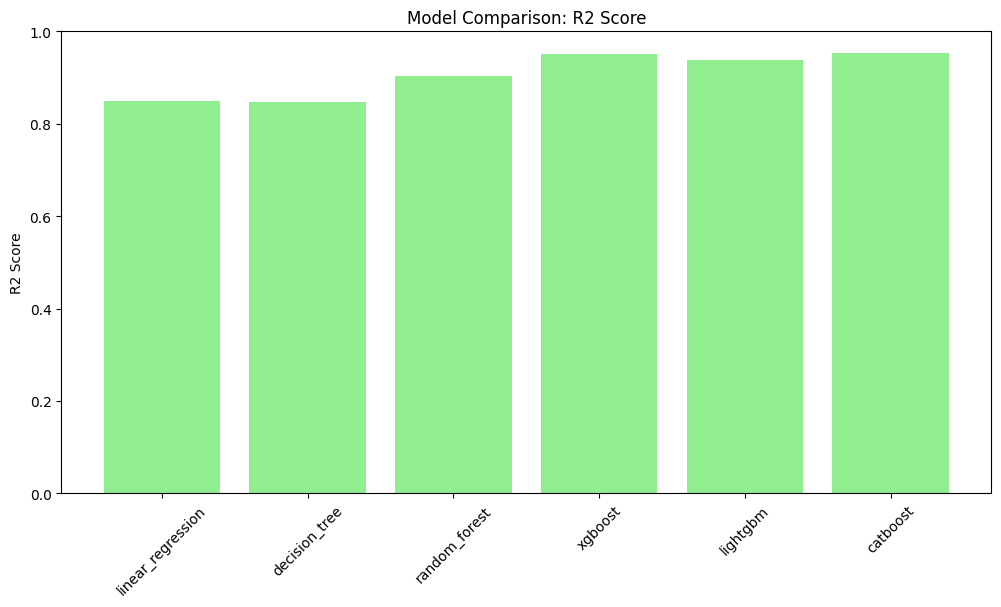

In [155]:
models_graph = list(results_cleaned.keys())
mae = [results_cleaned[m]['MAE'] for m in models_graph]
rmse = [results_cleaned[m]['RMSE'] for m in models_graph]
r2 = [results_cleaned[m]['R2'] for m in models_graph]

# Plot MAE and RMSE together
x = np.arange(len(models_graph))
width = 0.35

fig, ax1 = plt.subplots(figsize=(12,6))

ax1.bar(x - width/2, mae, width, label='MAE', color='skyblue')
ax1.bar(x + width/2, rmse, width, label='RMSE', color='salmon')
ax1.set_ylabel('Error')
ax1.set_xticks(x)
ax1.set_xticklabels(models_graph, rotation=45)
ax1.set_title('Model Comparison: MAE & RMSE')
ax1.legend()

plt.tight_layout()
plt.show()

# Plot R2 separately
plt.figure(figsize=(12,6))
plt.bar(models_graph, r2, color='lightgreen')
plt.ylabel('R2 Score')
plt.title('Model Comparison: R2 Score')
plt.ylim(0, 1)
plt.xticks(rotation=45)
plt.show()